# Introduction

This notebook presents my approach to the problem called **_"Build a model that predicts the number of hits per session."_** from Trivago.

## Table of Content

- Summary Information
- Analysis of missing values
- Outliers detection
- Input missing values
- Predictions
- Evaluation
- Conclusion

In [713]:
from string import ascii_letters
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

## 1. Summary information
<a id="load"></a>

In [714]:
#df = pd.read_csv('datasets/case_study/ML Data Scientist Case Study Data.csv', sep=";")
df = pd.read_csv('C:/Users/aghenda/Downloads/ML Data Scientist Case Study Data.csv', sep=";")

In [715]:
train = df.loc[df.hits != '\\N'] # train set 
test = df.loc[df.hits == '\\N'] # test set

In [716]:
print('Training dataset:\n', train.head(), '\n','-'*100, '\nTest dataset:\n', test.head())

Training dataset:
    row_num locale day_of_week  hour_of_day  agent_id  entry_page path_id_set  \
1   988680     L2    Thursday           22        10        2113     31965;0   
2   988679     L4    Saturday           21         2        2100     0;78464   
3   988678     L3    Saturday           19         8        2113       51462   
4   988677     L2     Tuesday            6        10        2116     31931;0   
5   988676     L3      Monday            1         8        2100           0   

   traffic_type session_durantion hits  
1             2                49   14  
2             1              1892   14  
3             6                 0    1  
4             1                 2    3  
5             1                 0    2   
 ---------------------------------------------------------------------------------------------------- 
Test dataset:
     row_num locale day_of_week  hour_of_day  agent_id  entry_page  \
0    988681     L6      Monday           17         1        2111 

In [717]:
print('Number train entries:', len(train), ', Number test entries:', len(test))

Number train entries: 619235 , Number test entries: 369446


In [718]:
print('train column names and types:', train.dtypes, sep='\n')
print('-'*28)
print('test column names and types:', test.dtypes, sep='\n')

train column names and types:
row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object
----------------------------
test column names and types:
row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object


In [719]:
print('Train data set:  \n\n', train.count(), '\n')
print('Test data set:  \n\n', test.count(), '\n')

Train data set:  

 row_num              619235
locale               619235
day_of_week          619235
hour_of_day          619235
agent_id             619235
entry_page           619235
path_id_set          616082
traffic_type         619235
session_durantion    619235
hits                 619235
dtype: int64 

Test data set:  

 row_num              369446
locale               369446
day_of_week          369446
hour_of_day          369446
agent_id             369446
entry_page           369446
path_id_set          367710
traffic_type         369446
session_durantion    369446
hits                 369446
dtype: int64 



In [720]:
print('Columns and types :  \n\n', train.dtypes, '\n')

Columns and types :  

 row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object 



## 2. Handling missing values

In [721]:
# We replace missing values denoted \N with NaN
train.replace('\\N', np.nan, inplace=True)
test.replace('\\N', np.nan, inplace=True)

In [722]:
df_columns = list(df.columns)
for column in df_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())

All entries in train set have non-null row_num : True
All entries in train set have non-null locale : True
All entries in train set have non-null day_of_week : True
All entries in train set have non-null hour_of_day : True
All entries in train set have non-null agent_id : True
All entries in train set have non-null entry_page : True
All entries in train set have non-null path_id_set : False
All entries in train set have non-null traffic_type : True
All entries in train set have non-null session_durantion : False
All entries in train set have non-null hits : True


In [723]:
for column in df_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

All entries in test set have non-null row_num : True
All entries in test set have non-null locale : True
All entries in test set have non-null day_of_week : True
All entries in test set have non-null hour_of_day : True
All entries in test set have non-null agent_id : True
All entries in test set have non-null entry_page : True
All entries in test set have non-null path_id_set : False
All entries in test set have non-null traffic_type : True
All entries in test set have non-null session_durantion : False
All entries in test set have non-null hits : False


Train data set: **path_id_set** and **session_durantion** contains missing values <br>
Test data set: **path_id_set**,  **session_durantion** and **hits** contains missing values

Let's now look at the proportion of missing values.

In [724]:
df_columns = list(df.columns)
for column in df_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')

Percentage of missing values for feature row_num : 0.0 %
Percentage of missing values for feature locale : 0.0 %
Percentage of missing values for feature day_of_week : 0.0 %
Percentage of missing values for feature hour_of_day : 0.0 %
Percentage of missing values for feature agent_id : 0.0 %
Percentage of missing values for feature entry_page : 0.0 %
Percentage of missing values for feature path_id_set : 0.51 %
Percentage of missing values for feature traffic_type : 0.0 %
Percentage of missing values for feature session_durantion : 0.07 %
Percentage of missing values for feature hits : 0.0 %


In [725]:
df_columns = list(df.columns)
for column in df_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Percentage of missing values for feature row_num : 0.0 %
Percentage of missing values for feature locale : 0.0 %
Percentage of missing values for feature day_of_week : 0.0 %
Percentage of missing values for feature hour_of_day : 0.0 %
Percentage of missing values for feature agent_id : 0.0 %
Percentage of missing values for feature entry_page : 0.0 %
Percentage of missing values for feature path_id_set : 0.47 %
Percentage of missing values for feature traffic_type : 0.0 %
Percentage of missing values for feature session_durantion : 0.07 %
Percentage of missing values for feature hits : 100.0 %


Globally the proportions of missing values are very low for the train set. <br>
I do not think that it is advisable to try to input **path_id_set**. Therefore, I decide to drop these rows. <br>
For **session_durantion**, I will find a strategy to input the missing values since they only represent 0.07%.

In the test set, same observations can be made.The percentage of missing values for hits is 100% but it is normal since we split our train / test set based on these missing values.

In [726]:
train.dropna(subset = ['path_id_set'], inplace=True)
test.dropna(subset = ['path_id_set'], inplace=True)

### Missing values: session_duration

In [727]:
# Let's have a quick look at the rows for which session_durantion is missing.
train[train.session_durantion.isnull()].head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
3562,985119,L3,Monday,0,8,8101,0,1,NaN,1
9948,978733,L2,Friday,7,7,8101,0,1,NaN,1
14262,974419,L3,Saturday,18,13,8101,0,1,NaN,1
20065,968616,L6,Tuesday,16,9,8101,0,1,NaN,1
21926,966755,L3,Wednesday,4,9,8101,0,1,NaN,1
24090,964591,L3,Tuesday,3,8,8101,0,1,NaN,1
24123,964558,L2,Tuesday,11,2,8101,0,1,NaN,1
26247,962434,L2,Thursday,7,2,8101,0,1,NaN,1
26990,961691,L2,Monday,11,7,8101,0,1,NaN,1
30190,958491,L1,Wednesday,2,8,8101,0,1,NaN,1


In [728]:
test[test.session_durantion.isnull()].head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
1153,987528,L3,Thursday,0,0,2226,34911;0,1,NaN,NaN
5171,983510,L6,Friday,15,6,8101,0,1,NaN,NaN
5349,983332,L2,Friday,19,7,8101,0,1,NaN,NaN
5563,983118,L3,Tuesday,14,9,8101,0,1,NaN,NaN
7816,980865,L1,Saturday,6,6,8101,0,1,NaN,NaN
9351,979330,L1,Sunday,14,7,8101,0,1,NaN,NaN
12791,975890,L6,Sunday,15,8,8101,0,1,NaN,NaN
15200,973481,L3,Saturday,15,9,8101,0,1,NaN,NaN
32428,956253,L3,Tuesday,0,9,8101,0,1,NaN,NaN
33574,955107,L6,Wednesday,9,9,8101,0,1,NaN,NaN


A first observation we can make is that it seems to particularly concern the entry page 8101, the traffic_type 1 and the path_id_set is 0. But let's dig more into that to understand what's happening.

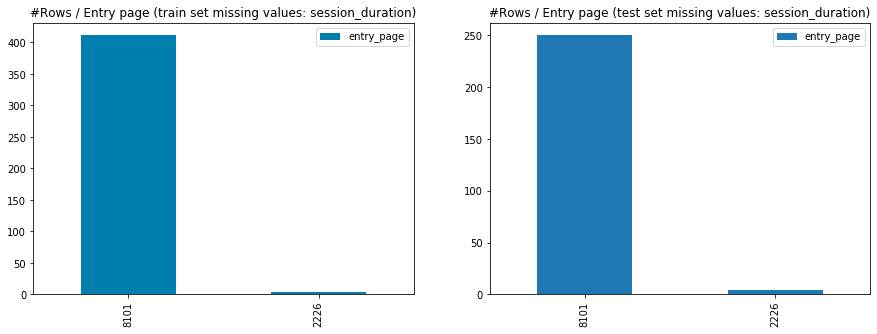

In [729]:
f, ax = plt.subplots(1,2, figsize=(15,5))
train[train.session_durantion.isnull()].entry_page.value_counts().plot('bar', ax=ax[0], color='#007faf', legend=True, title='#Rows / Entry page (train set missing values: session_duration)')
test[test.session_durantion.isnull()].entry_page.value_counts().plot('bar', ax=ax[1], legend=True, title='#Rows / Entry page (test set missing values: session_duration)')

Now it is obvious that there is a problem with the entry page 8101.

In [730]:
print('Train set: Traffic type for which the session_duration is missing:', train[train.session_durantion.isnull()].traffic_type.unique())
print('Test set: Traffic type for which the session_duration is missing:', test[test.session_durantion.isnull()].traffic_type.unique())

Train set: Traffic type for which the session_duration is missing: [1]
Test set: Traffic type for which the session_duration is missing: [1]


In [731]:
print('Train set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion:', round(len(train[(train['session_durantion'].isnull()) & (train.entry_page == 8101) & (train.traffic_type == 1)])/len(train[(train.entry_page == 8101)])*100, 2), '%')
print('Test set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion:', round(len(test[(test['session_durantion'].isnull()) & (test.entry_page == 8101) & (test.traffic_type == 1)])/len(test[(test.entry_page == 8101)])*100, 2), '%')

Train set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion: 98.09 %
Test set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion: 99.21 %


Traffic type 1 is the only one concerned by the missing values. I believe that there might be a problem with the entry page 8101 from the traffic type 1. I would crosscheck that with the web dev team to have more information. 

Now we want to input the missing values. However, the distribution of data is not normal and there are values that we believe are outliers. We will first deal with them before we use statistical measures to input the missing values.

## 3. Outliers detection

### Z-score

In [732]:
def zscore(series, threshold=3):
    z_score = (series-np.mean(series))/np.std(series)
    return np.abs(z_score) > threshold

### Modified Z-score

In [733]:
def modified_zscore(series, threshold=3):
    modified_z_score = 0.6745*(series-np.median(series))/series.mad()
    return np.abs(modified_z_score) > threshold

### Isolation forest

In [734]:
from sklearn.ensemble import IsolationForest

In [735]:
def isolation_forest(series):
    clf = IsolationForest(behaviour='new', contamination='auto', random_state=0)
    series = series.values.reshape(-1, 1)
    clf.fit(series)
    return clf.predict(series)

### Comparing outliers detection techniques

In [736]:
def get_proportion(series, inf, sup):
    return round((len(series[(series > inf) & (series < sup)]) / len(series))*100, 2)

In [737]:
def outlier_print(title, inliers, series):
    print('Outlier detection: {} identified outliers outside of the range [{}, {}]. Resulting outlier proportion: {}%.'.format(title, round(min(inliers)), round(max(inliers)), get_proportion(series, max(inliers), max(series)+1)))

In [738]:
def outliers_detection(series):
    inliers_zscore = series[~zscore(series)]
    outlier_print('Z-Score', inliers_zscore, series)
    inliers_modified_zscore = series[~modified_zscore(series)]
    outlier_print('Modified Z-Score', inliers_modified_zscore, series)
    inliers_isolation_forest = series[isolation_forest(series) == 1]
    outlier_print('Isolation Forest', inliers_isolation_forest, series)

In [739]:
# I exclude the missing values to find the outliers
train_without_missing_session = train[~train.session_durantion.isnull()]

In [740]:
train_without_missing_session.session_durantion = train_without_missing_session.session_durantion.astype('int')
train_without_missing_session.hits = train_without_missing_session.hits.astype('int')

In [741]:
train_without_missing_session.dtypes

row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion     int32
hits                  int32
dtype: object

##### Outliers detection: Session duration

In [742]:
outliers_detection(train_without_missing_session.session_durantion)

Outlier detection: Z-Score identified outliers outside of the range [0, 6245]. Resulting outlier proportion: 0.68%.
Outlier detection: Modified Z-Score identified outliers outside of the range [0, 2996]. Resulting outlier proportion: 3.33%.
Outlier detection: Isolation Forest identified outliers outside of the range [0, 556]. Resulting outlier proportion: 18.29%.


##### Outliers detection: Hits

In [743]:
outliers_detection(train_without_missing_session.hits)

Outlier detection: Z-Score identified outliers outside of the range [1, 135]. Resulting outlier proportion: 1.43%.
Outlier detection: Modified Z-Score identified outliers outside of the range [1, 86]. Resulting outlier proportion: 3.23%.
Outlier detection: Isolation Forest identified outliers outside of the range [2, 32]. Resulting outlier proportion: 13.88%.


We will use the Z-score that has the lowest proportion and drop the outliers.

In [744]:
def drop_outliers(df, column, mode=1):
    """ mode:
                1: Z-Score
                2: Modified Z-Score
                else: Isolation Forest
    """
    if mode == 1:
        inliers_zscore = df[column][~zscore(df[column])]
        max_inliers = round(max(inliers_zscore))
        df = df[df[column] < max_inliers] 
    elif mode == 2:
        inliers_modified_zscore = df[column][~modified_zscore(df[column])]
        max_inliers = round(max(inliers_modified_zscore))
        df = df[df[column] < max_inliers] 
    else:
        inliers_isolation_forest = df[column][isolation_forest(df[column]) == 1]
        max_inliers = round(max(inliers_isolation_forest))
        df = df[df[column] < max_inliers]    
    return df

In [745]:
train_without_missing_session = drop_outliers(train_without_missing_session, 'session_durantion', mode=1)

In [746]:
train_without_missing_session = drop_outliers(train_without_missing_session, 'hits', mode=1)

In [747]:
len(train_without_missing_session)

602070

In [748]:
# I concatenate missing sessions with the data set from which I removed outliers
train_only_missing_session = train[train.session_durantion.isnull()]
train = pd.concat([train_without_missing_session, train_only_missing_session])

## 4. Input missing values

### Feature: Session duration

C:\Users\aghenda\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


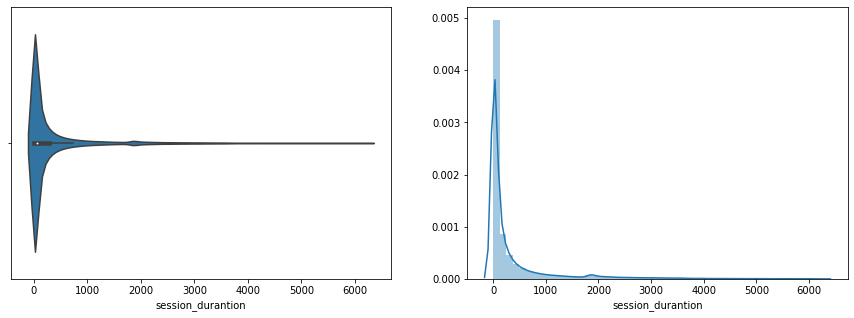

In [749]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.violinplot(train[~train.session_durantion.isnull()].session_durantion.astype('int32'), ax=axes[0])
sns.distplot(train[~train.session_durantion.isnull()].session_durantion.astype('int32'), ax=axes[1])

By looking at the boxplot and the distplot, we can make two observations:

1. Feature session_durantion is very skewed.
2. The majority of the data is concentrated between 0-1000

It makes me think that the mean would not be relevant. However, the median is this case makes more sense.

In [750]:
train.session_durantion.replace(np.nan, train.session_durantion.median(), inplace=True)

In [751]:
df_columns = list(df.columns)
for column in df_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())

All entries in train set have non-null row_num : True
All entries in train set have non-null locale : True
All entries in train set have non-null day_of_week : True
All entries in train set have non-null hour_of_day : True
All entries in train set have non-null agent_id : True
All entries in train set have non-null entry_page : True
All entries in train set have non-null path_id_set : True
All entries in train set have non-null traffic_type : True
All entries in train set have non-null session_durantion : True
All entries in train set have non-null hits : True


## 5. Data Preprocessing

#### Min-Max normalization

In [752]:
def min_max(series):
    series = (series - min(series)) / (max(series) - min(series))
    return series

#### Z-Score normalization

In [753]:
def zscore_norm(series):
    series = (series - series.mean()) / series.std()
    return series

#### Log-Transformation

In [754]:
def log_transformation(series):
    series = series.apply(lambda x: np.log(x+1))
    return series

#### One-Hot Encoding

In [755]:
column_to_encode = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page','traffic_type']

In [669]:
train = pd.get_dummies(train, columns=column_to_encode, drop_first=True)

## 6. Prediction

In [765]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.base import clone, TransformerMixin

#### Linear Regression

In [672]:
from sklearn.linear_model import LinearRegression

In [692]:
def linear_regression(df):
    X = df.drop(columns=['row_num', 'path_id_set','hits'])
    y = df['hits']
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf.get_n_splits(X)

    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    return y_pred

In [694]:
y_pred = linear_regression(train)

In [697]:
y_pred = [round(x) for x in y_pred]

In [699]:
y

1         14
2         14
3          1
4          3
5          2
6          2
7          3
8          3
9         45
10        39
11        15
12        24
13         5
14         3
19        40
22         2
23         4
24         4
25         3
28         3
29        40
30        33
31         4
32         3
33        29
35         3
36        30
38        62
39         4
40         6
          ..
914038     2
918196     2
920261     1
920262     1
924014     1
928066     1
928595     1
931892     1
932321     2
932787     1
934881     2
935530     1
937317     1
942030     1
943680     1
944325     1
945839     1
946210     2
950070     1
957197     1
959240     1
962577     1
964185     1
969137     3
969773     1
970962     1
977307     1
982710     2
983533     1
984753     1
Name: hits, Length: 602484, dtype: object

In [698]:
y_pred

[14.0,
 36.0,
 2.0,
 12.0,
 19.0,
 6.0,
 4.0,
 4.0,
 21.0,
 27.0,
 16.0,
 15.0,
 6.0,
 3.0,
 25.0,
 18.0,
 14.0,
 12.0,
 13.0,
 15.0,
 24.0,
 13.0,
 12.0,
 3.0,
 7.0,
 10.0,
 15.0,
 23.0,
 13.0,
 15.0,
 6.0,
 12.0,
 20.0,
 10.0,
 23.0,
 16.0,
 2.0,
 2.0,
 5.0,
 10.0,
 22.0,
 26.0,
 9.0,
 16.0,
 22.0,
 10.0,
 18.0,
 6.0,
 21.0,
 8.0,
 42.0,
 39.0,
 14.0,
 6.0,
 7.0,
 12.0,
 22.0,
 7.0,
 10.0,
 21.0,
 16.0,
 14.0,
 21.0,
 20.0,
 5.0,
 2.0,
 21.0,
 12.0,
 20.0,
 54.0,
 15.0,
 13.0,
 5.0,
 11.0,
 2.0,
 3.0,
 39.0,
 13.0,
 19.0,
 3.0,
 15.0,
 21.0,
 12.0,
 11.0,
 14.0,
 4.0,
 18.0,
 25.0,
 15.0,
 12.0,
 27.0,
 7.0,
 13.0,
 23.0,
 22.0,
 19.0,
 18.0,
 11.0,
 38.0,
 15.0,
 12.0,
 39.0,
 6.0,
 15.0,
 7.0,
 19.0,
 6.0,
 1.0,
 12.0,
 23.0,
 2.0,
 2.0,
 8.0,
 17.0,
 40.0,
 25.0,
 14.0,
 21.0,
 19.0,
 34.0,
 13.0,
 3.0,
 8.0,
 17.0,
 19.0,
 19.0,
 0.0,
 20.0,
 19.0,
 9.0,
 2.0,
 12.0,
 12.0,
 7.0,
 3.0,
 19.0,
 23.0,
 5.0,
 19.0,
 13.0,
 6.0,
 13.0,
 31.0,
 4.0,
 15.0,
 7.0,
 28.0,
 41.0,
 3.0,
 1

#### Decision Tree

#### Random Forest

#### XGB Regressor

## 7. Evalution

In [686]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def root_mean_squared_error(y_actual, y_pred):
    rmse = sqrt(mean_squared_error(y_actual, y_pred))
    return rmse

In [689]:
root_mean_squared_error(y, y_pred)

15.705766190412767

## Conclusion